In [200]:
# File Imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib.ticker as ticker
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Needed for decision tree visualization
import pydotplus 
from IPython.display import Image

# Suppress Warnings
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.simplefilter("ignore", category=FutureWarning)

## Step 1: Load Salary data and perform binning

In [201]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)

# salary_cap = 320000
# salary_df = salary_df.loc[salary_df["salary_in_usd"] <= salary_cap]

# Display the DataFrame:
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


<module 'matplotlib.pyplot' from '/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

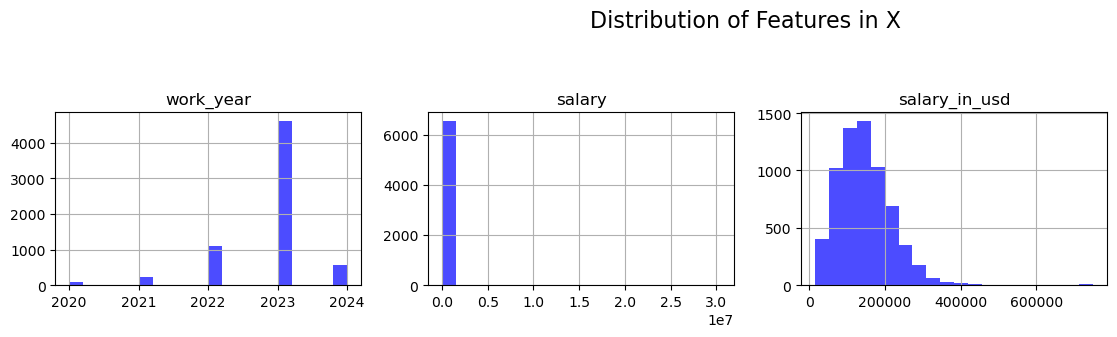

In [202]:
# Graph Feature Dat:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature in X
X = salary_df.select_dtypes(include=['float64', 'int64'])  # Select numerical features
X.hist(bins=20, figsize=(15, 10), layout=(4, 4), color='blue', alpha=0.7)
plt.suptitle('Distribution of Features in X', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt

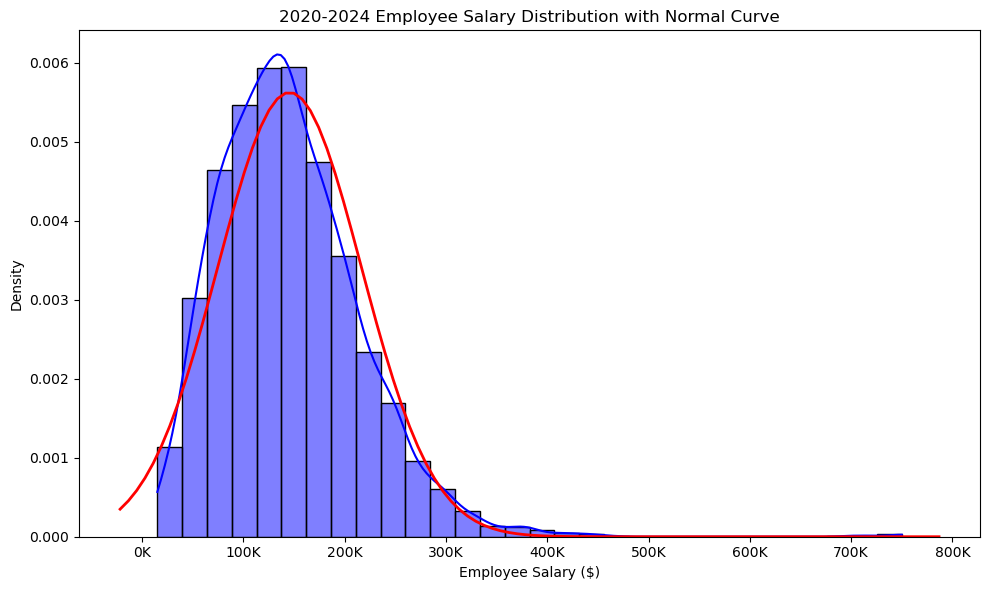

In [203]:
# Choose a specific column from X or y
feature_to_plot = X.iloc[:, 2]  # Replace 2 with the actual column index you want

# Check if the data is numeric. If not, you can't scale it.
if not pd.api.types.is_numeric_dtype(feature_to_plot):
    print("Error: The selected feature is not numeric. Cannot scale.")
    exit() # Or handle the non-numeric case appropriately

# Scale the data by 1000 (if it's salary or similar):
feature_to_plot_scaled = feature_to_plot / 1000

# Plot the histogram with KDE using the SCALED data:
plt.figure(figsize=(10, 6))
sns.histplot(feature_to_plot_scaled, kde=True, stat="density", color="blue", bins=30)

# Overlay the normal distribution (using the SCALED mean and std):
mean_scaled = feature_to_plot_scaled.mean()
std_scaled = feature_to_plot_scaled.std()
xmin_scaled, xmax_scaled = plt.xlim()
x_scaled = np.linspace(xmin_scaled, xmax_scaled, 100)
p_scaled = norm.pdf(x_scaled, mean_scaled, std_scaled)
plt.plot(x_scaled, p_scaled, 'r', linewidth=2)


plt.title('2020-2024 Employee Salary Distribution with Normal Curve')  # More general title
plt.xlabel('Employee Salary ($)')  # More general x-axis label
plt.ylabel('Density')

# Format x-axis ticks to show thousands (if applicable):
def format_thousands(x, pos):
    return f'{x:.0f}K'

formatter = ticker.FuncFormatter(format_thousands)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig("./images/salary_distribution_scaled.png", dpi=300)
plt.show()

In [204]:
# Data Partitioning: Attempt 1 of 2: Calculate the average range based on the 68% of the Empirical rule
mean_salary = np.mean(feature_to_plot)
std_salary = np.std(feature_to_plot)

lower_bound = mean_salary - std_salary
upper_bound = mean_salary + std_salary

print(f"68% range: ({lower_bound}, {upper_bound})")

68% range: (74619.09627855755, 216502.0208604029)


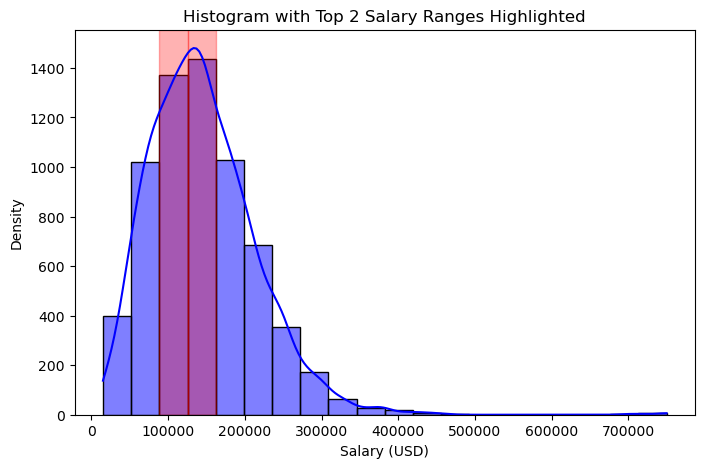

Top 2 most frequent salary ranges: [(88500.0, 125250.0), (125250.0, 162000.0)]


In [205]:
# Data Partitionaing: Attempt 2 of 2: Using the two highest bars as the average
counts, bin_edges = np.histogram(feature_to_plot, bins=20)  # Adjust bins as needed

# Find indices of the two highest bins
top_2_indices = np.argsort(counts)[-2:]  # Get the two highest bins

# Get the corresponding salary ranges
top_2_ranges = [(bin_edges[i], bin_edges[i+1]) for i in top_2_indices]

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(feature_to_plot, bins=20, kde=True, color="blue", alpha=0.5)

# Highlight the two highest bars
for low, high in top_2_ranges:
    plt.axvspan(low, high, color="red", alpha=0.3)  # Highlight range

plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.title("Histogram with Top 2 Salary Ranges Highlighted")


plt.show()

# Print the identified ranges
print(f"Top 2 most frequent salary ranges: {top_2_ranges}")

In [206]:
# Binning Employee Salary (y):

# Visual observation of the range of the Highest two bars
bins = [1500, 50000, 156000, 176000, 750000]

# Peak salaries as average
# bins = [1500, 60000, 125000, 175000, 750000]

# Statical calculation of the range for the Highest two bars
# bins = [1500, 50000, 85000, 162000, 750000]

# Evenly distributed bins:
# bins = [1500, 50000, 100000, 140000, 750000]

# 5 distribution split
# bins = [1500, 50000, 100000, 140000, 200000, 750000] 

# PDCUT: Binning
# salary_df["Employee Salary"], bin_edges = pd.qcut(salary_df["salary_in_usd"], q=4, labels=False, retbins=True)

# Create labels for these bins
group_names = ["very low", "low", "average", "high"]

salary_data = X["salary_in_usd"]
# Slice the data and place it into bins
binned_data = pd.cut(salary_data, bins, labels=group_names, include_lowest=True)
display("Binned Data:", binned_data)
display("Binned Data Info")
binned_data.info()
salary_binned = pd.DataFrame()

# Place the data series into Employee Salary DataFrame
salary_binned["Employee Salary"] = binned_data


'Binned Data:'

0            low
1            low
2            low
3            low
4            low
          ...   
6594    very low
6595    very low
6596         low
6597         low
6598         low
Name: salary_in_usd, Length: 6599, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Binned Data Info'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


## Step 2: Calculate the employee count and avg salary, per category

In [207]:
# Create DataFrame with binned categories and original salaries
salary_and_bin = pd.DataFrame({"Employee Salary": salary_data, "Salary Bin": binned_data})


# Compute count and mean for each bin
salary_stats = salary_and_bin.groupby("Salary Bin", observed=False)["Employee Salary"].agg(['count', 'mean'])
# Rename columns for clarity
salary_stats.columns = ["Employee Count", "Average Salary"]

# Display as a table
print(salary_stats)

            Employee Count  Average Salary
Salary Bin                                
very low               383    37378.916449
low                   3651   108564.775952
average                652   166347.731595
high                  1913   230741.914794


## Step 3: Data Preprocessing

In [208]:
# Load X dataset:
# Drop collinear data:
X = salary_df.copy()
# X = X.drop(columns=["salary", "salary_currency", "salary_in_usd", "work_year"], axis=1)
X = X.drop(columns=["salary", "salary_currency", "salary_in_usd"], axis=1)

display("X Info:")
X.info()
display("X Data:", X.head())
display("Work Model value_counts:", X["work_models"].value_counts())

# Get Nominal Column Names Only
nominal_features = X.select_dtypes(include="object").columns

'X Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   company_location    6599 non-null   object
 7   company_size        6599 non-null   object
dtypes: int64(1), object(7)
memory usage: 412.6+ KB


'X Data:'

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,United States,Medium


'Work Model value_counts:'

work_models
On-site    3813
Remote     2561
Hybrid      225
Name: count, dtype: int64

In [209]:
# Load Y dataset:
y = binned_data
display("X shape:", X.shape)
display("y data:", y[0:5])
display("Y Info:")
y.info()

display("Y shape:", y.shape)
display("Y Describe:", y.describe())
# Check Y distribution
display("Y Value Counts:", y.value_counts())


'X shape:'

(6599, 8)

'y data:'

0    low
1    low
2    low
3    low
4    low
Name: salary_in_usd, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Y Info:'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


'Y shape:'

(6599,)

'Y Describe:'

count     6599
unique       4
top        low
freq      3651
Name: salary_in_usd, dtype: object

'Y Value Counts:'

salary_in_usd
low         3651
high        1913
average      652
very low     383
Name: count, dtype: int64

## Step 4: Data Encoding

In [210]:
# Preprocessing: Convert Nominal to Ordinal Data with Get Dummies:

X_encoded = pd.get_dummies(X, columns=nominal_features, drop_first=True, dtype=int)
# y_encoded = pd.get_dummies(y, drop_first=True, dtype=int)
le = LabelEncoder()
# One column only (reshape)
y_encoded = le.fit_transform(y)
y_encoded_1_dim = y_encoded
# print("y_encoded:", y_encoded.tolist())
# display("y_encoded:", y_encoded)

y_encoded = y_encoded.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=1)

display("xTrain:", X_train)
display("yTrain:", y_train)

'xTrain:'

,work_year,job_title_AI Developer,job_title_AI Engineer,job_title_AI Product Manager,job_title_AI Programmer,job_title_AI Research Engineer,job_title_AI Scientist,job_title_AWS Data Architect,job_title_Analytics Engineer,job_title_Analytics Engineering Manager,...,company_location_Switzerland,company_location_Thailand,company_location_Turkey,company_location_Ukraine,company_location_United Arab Emirates,company_location_United Kingdom,company_location_United States,company_location_Vietnam,company_size_Medium,company_size_Small
477,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1989,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
711,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3234,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2857,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5192,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3980,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
235,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


'yTrain:'

array([[1],
       [1],
       [2],
       ...,
       [0],
       [1],
       [1]])

## Step 5: BaseCase: Training 5 Classification Models

In [211]:
# Baseline Pipeline Model Fitting:
# pipe = Pipeline([("Scale", StandardScaler()), ("LR", LinearRegression())])
# KNeighborsClassifier(n_neighbors=5)

models = {
    # Use odd generic number (5) for n_neighbors tie breakers 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    # Use generic max_depth of 5
    "DTC": DecisionTreeClassifier(max_depth=5),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier(algorithm="SAMME.R")
}

for name, model in models.items():
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])
                                                
    # Fit (Train) the Model
    pipe.fit(X_train, y_train)

    # Make a prediction
    y_pred = pipe.predict(X_test)
    
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5606060606060606
              precision    recall  f1-score   support

           0       0.16      0.07      0.10       165
           1       0.44      0.61      0.51       448
           2       0.68      0.66      0.67       945
           3       0.36      0.20      0.25        92

    accuracy                           0.56      1650
   macro avg       0.41      0.38      0.38      1650
weighted avg       0.55      0.56      0.55      1650

SVC Score: 0.5933333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.50      0.38      0.43       448
           2       0.62      0.84      0.72       945
           3       0.46      0.14      0.22        92

    accuracy                           0.59      1650
   macro avg       0.40      0.34      0.34      1650
weighted avg       0.52      0.59      0.54      1650

DTC Score: 0.6066666666666667
              precision    recall  f1-sc

## Step 6: Model Optimization

In [212]:
# Part 1: Scale and Split data and find Best KNN value:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 5, Train Score: 0.604 | Test Score: 0.561
k: 7, Train Score: 0.606 | Test Score: 0.572
k: 9, Train Score: 0.612 | Test Score: 0.590
k: 11, Train Score: 0.609 | Test Score: 0.590
k: 13, Train Score: 0.612 | Test Score: 0.596
k: 15, Train Score: 0.608 | Test Score: 0.597
k: 17, Train Score: 0.608 | Test Score: 0.598
k: 19, Train Score: 0.610 | Test Score: 0.604
k: 21, Train Score: 0.608 | Test Score: 0.604
k: 23, Train Score: 0.604 | Test Score: 0.601


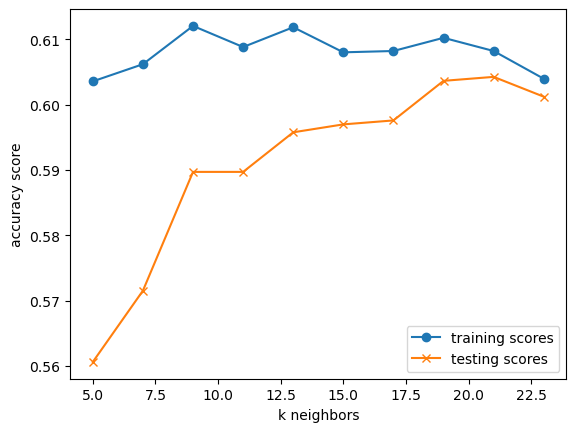

In [213]:
# KNN Optimization 1: Find Best K_nearest neighbor value
train_scores = []
test_scores = []

for k in range(5, 25, 2):
    # Use KNN Classifer Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Score for training
    train_score = knn.score(X_train_scaled, y_train)
    
    # Score for the test
    test_score = knn.score(X_test_scaled, y_test)
    
    # add the caculated scores to the list we just calculated
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train Score: {train_score:.3f} | Test Score: {test_score:.3f}")
    
# PyPlot Library: Plot the results
# Plot training scores, we need the saved k range for x axis on plot
# Optimal score would be 9, because that is where the testing scores are
# better than our training data.  The first whole number after the testing 
# and training data cross
plt.plot(range(5, 25, 2), train_scores, marker='o', label="training scores")
plt.plot(range(5, 25, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [214]:
# KNN Optimation 1: Results with best KNN value:
knn_21 = KNeighborsClassifier(n_neighbors=21)
knn_21.fit(X_train_scaled, y_train)
print('k=21 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))
predictions_knn_21 = knn_21.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_knn_21, target_names=target_names))

k=21 Test Acc: 0.601


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.40      0.42      0.41       448
           2       0.62      0.77      0.69       945
           3       0.00      0.00      0.00        92

    accuracy                           0.55      1650
   macro avg       0.25      0.30      0.27      1650
weighted avg       0.46      0.55      0.50      1650



/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [215]:
# KNN Optimization 2: Untuned KNN Model Classification Results
untuned_model = KNeighborsClassifier(n_neighbors=5)
untuned_model.fit(X_train, y_train)
print('Untuned_Model Accuracy Score: %.3f' % untuned_model.score(X_test_scaled, y_test))
# predicted
predictions_untuned = untuned_model.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_untuned, target_names=target_names))

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Untuned_Model Accuracy Score: 0.516
              precision    recall  f1-score   support

           0       0.18      0.05      0.08       165
           1       0.46      0.58      0.52       448
           2       0.68      0.71      0.70       945
           3       0.60      0.32      0.41        92

    accuracy                           0.59      1650
   macro avg       0.48      0.42      0.43      1650
weighted avg       0.57      0.59      0.57      1650



In [216]:
# # KNN Option 2a: GridSearchCV Estimator
# # NOT STOPPING: 
# # Find the best params to hypertune the model
# grid_tuned_model = KNeighborsClassifier(n_neighbors=5)
# # every other because it takes a long time, could do all

# # create dictionary with parameters
# grid_parameters = {
#     "n_neighbors": np.arange(11, 21, 2),
#     "leaf_size": np.arange(1, 501),
#     "weights": ["uniform", "distance"]
# }

# # Create the instance of GridSearch CV model, with parameters
# grid_model = GridSearchCV(grid_tuned_model, grid_parameters, verbose=3)

# # Fit the model by using the grid search estimator.
# grid_model.fit(X_train, y_train)
# # List the best parameters for this dataset
# # what is the best leafsize, and params
# print(grid_model.best_params_)

In [217]:
# # KNN Optimization 2b: Rerun model with GridSearchCV Best Fit Estimator
# # Use the best parameters found
# grid_tuned_model = KNeighborsClassifier(
#     n_neighbors=15,  # Best fit value
#     leaf_size=221,    # Best fit value
#     weights="uniform" # Best fit value
#     )

# grid_tuned_model.fit(X_train, y_train)
# print('Random _Tuned_Model Accuracy Score: %.3f' % grid_tuned_model.score(X_test_scaled, y_test))

# # List the best parameters for this dataset
# print("BEST FIT:", grid_tuned_model.best_params_)

# # Make predictions with the hypertuned model
# predictions_tuned = grid_tuned_model.predict(X_test)
# target_names = ["0", "1", "2", "3"]
# print(classification_report(y_test, predictions_tuned, target_names=target_names))

In [218]:
# KNN Optimiataion 2a:  RandomizedSearchCV Estimator
random_tuned_model = KNeighborsClassifier(n_neighbors=5)
random_parameters = {
    "n_neighbors": np.arange(5, 21, 2),
    "leaf_size": np.arange(1, 501),
    "weights": ["uniform", "distance"]
}

random_tuned_model = RandomizedSearchCV(random_tuned_model, random_parameters, verbose=3)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# List the best parameters for this dataset
print("BEST FIT:", random_tuned_model.best_params_)

# Make predictions with the hypertuned model
predications_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predications_random,target_names=target_names))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=282, n_neighbors=15, weights=distance;, score=0.534 total time=   0.1s
[CV 2/5] END leaf_size=282, n_neighbors=15, weights=distance;, score=0.582 total time=   0.1s
[CV 3/5] END leaf_size=282, n_neighbors=15, weights=distance;, score=0.562 total time=   0.1s
[CV 4/5] END leaf_size=282, n_neighbors=15, weights=distance;, score=0.581 total time=   0.1s
[CV 5/5] END leaf_size=282, n_neighbors=15, weights=distance;, score=0.548 total time=   0.1s
[CV 1/5] END leaf_size=29, n_neighbors=19, weights=uniform;, score=0.572 total time=   0.1s
[CV 2/5] END leaf_size=29, n_neighbors=19, weights=uniform;, score=0.610 total time=   0.1s
[CV 3/5] END leaf_size=29, n_neighbors=19, weights=uniform;, score=0.560 total time=   0.1s
[CV 4/5] END leaf_size=29, n_neighbors=19, weights=uniform;, score=0.584 total time=   0.1s
[CV 5/5] END leaf_size=29, n_neighbors=19, weights=uniform;, score=0.578 total time=   0.1s
[CV 1/5] 

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [219]:
# KNN Optimization 2b: Rerun model with RandomizedSearchCV Best Fit Estimator
# Use the best parameters found
random_tuned_model = KNeighborsClassifier(
    n_neighbors=15,  # Best fit value
    leaf_size=221,    # Best fit value
    weights="uniform" # Best fit value
    )

random_tuned_model.fit(X_train, y_train)
print('Random Model Accuracy Score: %.3f' % random_tuned_model.score(X_test_scaled, y_test))

# predicted
predictions_tuned = random_tuned_model.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_tuned, target_names=target_names))

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Random Model Accuracy Score: 0.532
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.48      0.57      0.53       448
           2       0.67      0.77      0.72       945
           3       0.73      0.21      0.32        92

    accuracy                           0.61      1650
   macro avg       0.47      0.39      0.39      1650
weighted avg       0.56      0.61      0.57      1650



In [220]:
# Optimization 3: RandomOverSampling and RandomUnderSampling
# #Deterimine if  y_encoded is unbalaced:  
# Results indicate uneven distribution, between class 3 (least) and 2 (most)
# Recommendation: OverSampling


print("y_encoded:")
display(pd.Series(y_encoded_1_dim).value_counts())
'''
Class 2 has 3651 samples (dominant class).
Class 1 has 1913 samples.
Class 0 has 652 samples.
Class 3 has 383 samples (least frequent).
'''

y_encoded:


2    3651
1    1913
0     652
3     383
Name: count, dtype: int64

'\nClass 2 has 3651 samples (dominant class).\nClass 1 has 1913 samples.\nClass 0 has 652 samples.\nClass 3 has 383 samples (least frequent).\n'

In [221]:
# Optimization 3a: RandomOverSampling
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = over_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Oversampled Class Distribution")
print(pd.Series(y_train_oversampled).value_counts())

Oversampled Class Distribution
1    2706
2    2706
3    2706
0    2706
Name: count, dtype: int64


In [222]:
# Optimization 3b: Rerun Models with RandomOverSampling dataset
# Results Worse
models = {
    "KNN": KNeighborsClassifier(
    n_neighbors=15,  # Best fit value
    leaf_size=221,    # Best fit value
    weights="uniform" # Best fit value
    ),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5066666666666667
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       165
           1       0.46      0.51      0.48       448
           2       0.67      0.55      0.60       945
           3       0.33      0.67      0.44        92

    accuracy                           0.51      1650
   macro avg       0.40      0.47      0.42      1650
weighted avg       0.54      0.51      0.52      1650

SVC Score: 0.4036363636363636
              precision    recall  f1-score   support

           0       0.13      0.58      0.22       165
           1       0.52      0.40      0.45       448
           2       0.78      0.34      0.48       945
           3       0.38      0.71      0.49        92

    accuracy                           0.40      1650
   macro avg       0.45      0.51      0.41      1650
weighted avg       0.62      0.40      0.45      1650

DTC Score: 0.4715151515151515
              precision    recall  f1-sc

In [223]:
# Optimization 4a: RandomUnderSampling:
# Apply Random Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=1)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_undersampled).value_counts())

0    291
1    291
2    291
3    291
Name: count, dtype: int64


In [224]:
# Optimization 4b: Rerun Models with UnderSampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()  
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_undersampled, y_train_undersampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Score: KNN; 0.27151515151515154
KNN Score: 0.27151515151515154
              precision    recall  f1-score   support

           0       0.12      0.78      0.21       165
           1       0.38      0.17      0.24       448
           2       0.80      0.20      0.31       945
           3       0.34      0.61      0.43        92

    accuracy                           0.27      1650
   macro avg       0.41      0.44      0.30      1650
weighted avg       0.60      0.27      0.29      1650

Score: SVC; 0.4
SVC Score: 0.4
              precision    recall  f1-score   support

           0       0.14      0.39      0.20       165
           1       0.46      0.57      0.51       448
           2       0.79      0.28      0.42       945
           3       0.26      0.78      0.39        92

    accuracy                           0.40      1650
   macro avg       0.41      0.51      0.38      1650
weighted avg       0.60      0.40      0.42      1650

Score: DTC; 0.3939393939393939
DTC S

In [225]:
# Optimization 5a: SMOTEENN ReSampling:
# Apply Random Under Sampling
smt_sampler = SMOTEENN(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = smt_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Classification Distribution")
print(pd.Series(y_train_resampled).value_counts())

Classification Distribution
3    2202
0     629
2     378
1     290
Name: count, dtype: int64


In [232]:
# Optimization 5b: Rerun Models with SMOTEEN Resampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


KNN Score: 0.3903030303030303
              precision    recall  f1-score   support

           0       0.12      0.37      0.18       165
           1       0.48      0.27      0.34       448
           2       0.65      0.42      0.51       945
           3       0.25      0.75      0.38        92

    accuracy                           0.39      1650
   macro avg       0.37      0.45      0.35      1650
weighted avg       0.53      0.39      0.42      1650

SVC Score: 0.34424242424242424
              precision    recall  f1-score   support

           0       0.12      0.52      0.20       165
           1       0.51      0.31      0.39       448
           2       0.75      0.28      0.41       945
           3       0.25      0.86      0.38        92

    accuracy                           0.34      1650
   macro avg       0.41      0.49      0.34      1650
weighted avg       0.59      0.34      0.38      1650

DTC Score: 0.38727272727272727
              precision    recall  f1-

In [264]:
# Optimization 6a: AdaBoost RandomizedSearchCV Estimator
random_tuned_model = AdaBoostClassifier()
# AdaBoost Parameter Grid
param_grid = {
    "n_estimators": np.arange(50, 201, 2),  # Example: Number of weak learners
    "learning_rate": np.logspace(-3, 0, 20),  # Example: Learning rate (log scale)
    "algorithm": ['SAMME', 'SAMME.R'] #SAMME.R converges faster
}

# RandomizedSearchCV for AdaBoost
random_tuned_model = RandomizedSearchCV(
    AdaBoostClassifier(), 
    param_grid, 
    n_iter=10, 
    cv=5, 
    verbose=3, 
    n_jobs=-1, 
    scoring='accuracy', #Added scoring and cross validation
    random_state=61 #Added random state
)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# Best Parameters
print("BEST FIT:", random_tuned_model.best_params_)

# Predictions
predictions_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predictions_random, target_names=target_names))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 4/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.7s
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=74;, score=0.547 total time=   0.7s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.8s[CV 5/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=74;, score=0.547 total time=   0.7s

[CV 2/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.8s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 4/5] END algorithm=SAMME.R, learning_rate=0.11288378916846883, n_estimators=150;, score=0.590 total time=   1.2s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.11288378916846883, n_estimators=150;, score=0.589 total time=   1.2s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 1/5] END algorithm=SAMME.R, learning_rate=0.11288378916846883, n_estimators=150;, score=0.558 total time=   1.4s
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=110;, score=0.547 total time=   0.9s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.11288378916846883, n_estimators=150;, score=0.589 total time=   1.6s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.11288378916846883, n_estimators=150;, score=0.564 total time=   1.6s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=110;, score=0.546 total time=   0.9s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 3/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=110;, score=0.546 total time=   1.1s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=110;, score=0.546 total time=   1.1s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.012742749857031334, n_estimators=110;, score=0.547 total time=   1.1s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 1/5] END algorithm=SAMME.R, learning_rate=0.018329807108324356, n_estimators=136;, score=0.547 total time=   1.1s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.018329807108324356, n_estimators=136;, score=0.546 total time=   1.0s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.018329807108324356, n_estimators=136;, score=0.546 total time=   1.1s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END algorithm=SAMME.R, learning_rate=0.018329807108324356, n_estimators=136;, score=0.546 total time=   1.2s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.018329807108324356, n_estimators=136;, score=0.547 total time=   1.2s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.4832930238571752, n_estimators=142;, score=0.584 total time=   1.2s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.4832930238571752, n_estimators=142;, score=0.566 total time=   1.3s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.4832930238571752, n_estimators=142;, score=0.598 total time=   1.2s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.4832930238571752, n_estimators=142;, score=0.604 total time=   1.3s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END algorithm=SAMME.R, learning_rate=0.4832930238571752, n_estimators=142;, score=0.600 total time=   1.3s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=164;, score=0.546 total time=   1.4s
[CV 1/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=164;, score=0.547 total time=   1.4s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=164;, score=0.545 total time=   1.4s
[CV 4/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=164;, score=0.547 total time=   1.3s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=164;, score=0.547 total time=   1.4s
[CV 2/5] END algorithm=SAMME, learning_rate=0.008858667904100823, n_estimators=80;, score=0.546 total time=   0.6s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END algorithm=SAMME, learning_rate=0.008858667904100823, n_estimators=80;, score=0.547 total time=   0.7s
[CV 1/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=192;, score=0.547 total time=   1.6s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=192;, score=0.547 total time=   1.6s
[CV 3/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=192;, score=0.546 total time=   1.5s
[CV 3/5] END algorithm=SAMME, learning_rate=0.008858667904100823, n_estimators=80;, score=0.546 total time=   0.7s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 4/5] END algorithm=SAMME, learning_rate=0.008858667904100823, n_estimators=80;, score=0.546 total time=   0.7s
[CV 5/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=192;, score=0.546 total time=   1.6s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=192;, score=0.546 total time=   1.7s
[CV 1/5] END algorithm=SAMME, learning_rate=0.004281332398719396, n_estimators=50;, score=0.547 total time=   0.4s
[CV 5/5] END algorithm=SAMME, learning_rate=0.008858667904100823, n_estimators=80;, score=0.547 total time=   0.6s
[CV 2/5] END algorithm=SAMME, learning_rate=0.004281332398719396, n_estimators=50;, score=0.546 total time=   0.4s
[CV 3/5] END algorithm=SAMME, learning_rate=0.004281332398719396, n_estimators=50;, score=0.546 total time=   0.4s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 4/5] END algorithm=SAMME, learning_rate=0.004281332398719396, n_estimators=50;, score=0.546 total time=   0.4s
[CV 5/5] END algorithm=SAMME, learning_rate=0.004281332398719396, n_estimators=50;, score=0.547 total time=   0.4s
[CV 1/5] END algorithm=SAMME, learning_rate=0.0379269019073225, n_estimators=86;, score=0.547 total time=   0.6s
[CV 2/5] END algorithm=SAMME, learning_rate=0.0379269019073225, n_estimators=86;, score=0.546 total time=   0.6s
[CV 3/5] END algorithm=SAMME, learning_rate=0.0379269019073225, n_estimators=86;, score=0.546 total time=   0.6s
[CV 4/5] END algorithm=SAMME, learning_rate=0.0379269019073225, n_estimators=86;, score=0.546 total time=   0.6s
[CV 5/5] END algorithm=SAMME, learning_rate=0.0379269019073225, n_estimators=86;, score=0.547 total time=   0.6s
BEST FIT: {'n_estimators': 142, 'learning_rate': 0.4832930238571752, 'algorithm': 'SAMME.R'}
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       165
   

In [265]:
# Optimization 6b: Rerun AdaBoost with RandomizedSearchCV Best Fit:

best_params = {
    'n_estimators': 142, 
    'learning_rate': 0.4832930238571752, 
    'algorithm': 'SAMME.R',
    'random_state': 61}

# Create and train the AdaBoost classifier with the best parameters
best_ada = AdaBoostClassifier(**best_params)  # Use ** to unpack the dictionary
best_ada.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_ada.predict(X_test)

print(f'AdaBost Score: {best_ada.score(X_test, y_test)}')


# Evaluate the model
target_names = ["0", "1", "2", "3"]  # Your target names
print(classification_report(y_test, predictions, target_names=target_names))

# #If you want to use the model later, you can save it.
# import joblib
# joblib.dump(best_ada, 'adaboost_model.pkl') #Save the model
# #To load the model later:
# #loaded_ada = joblib.load('adaboost_model.pkl')

AdaBost Score: 0.6321212121212121
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       165
           1       0.53      0.49      0.51       448
           2       0.67      0.83      0.74       945
           3       0.64      0.41      0.50        92

    accuracy                           0.63      1650
   macro avg       0.59      0.43      0.44      1650
weighted avg       0.61      0.63      0.59      1650

